**Time Series Forecasting | Prediksi Harga Minyak (Brent Crude Oil)**

*Hairul Yasin*



**Latar Belakang & Business Understanding**

Harga minyak dunia memiliki hubungan yang erat dengan harga aspal.  Aspal merupakan produk turunan minyak bumi yang digunakan untuk pembangunan jalan, konstruksi, dan infrastruktur lainnya.  Fluktuasi harga minyak dunia secara langsung mempengaruhi biaya produksi aspal, yang pada akhirnya berdampak pada harga jual aspal di pasaran.

Bagi perusahaan Aspal, prediksi harga minyak dunia menjadi informasi penting untuk:
1. Membuat strategi penetapan harga
2. Memanajemen biaya produksi
3. Membuat keputusan investasi
4. Meningkatkan daya saing

**Tujuan** : Mengembangkan model prediksi harta minyak yang akurat dan menyediakan informasi prediksi harga minyak

**Solusi** : Untuk mengatasi masalah ini saya akan menggunakan dua algoritma yang berbeda yakni dengan pendekatan ARIMA dan LSTM,

In [1]:
# Import library

!pip install -q pmdarima  # untuk auto arima -> memilih p,d,q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler

In [2]:
# Fungsi untuk menghitung metrik evaluasi
def calculate_metrics(y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

# **Data Understanding**

In [3]:
# Eksplorasi Data (EDA)
url = 'https://raw.githubusercontent.com/hairulysin/streamlitDashboard/main/data/oil_data.csv'
data = pd.read_csv(url)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        759 non-null    object 
 1   Close       759 non-null    float64
 2   chg.close.  759 non-null    float64
 3   Low         759 non-null    float64
 4   chg.low.    759 non-null    float64
 5   High        759 non-null    float64
 6   chg.high.   759 non-null    float64
dtypes: float64(6), object(1)
memory usage: 41.6+ KB
None


Data yang diunakan kali ini ialah berasal dari Google Finance mengenai Brent Crude Oil. Data saat ini9 berjumlah 759 observasi, tidak ada missing value, sehingga data siap untuk pemodelan.

Deskripsi Variabel :   
1. Date      : Tanggal Observasi
2. Close     : Harga penutupan minyak pada tanggal observasi
3. chg.close : Perubahan harga penutupan minyak dibandingkan hari sebelumnya
4. Low       : Harga terendah minyak pada tanggal observasi
5. chg.low.  : Perubahan harga terendah minyak dibandingkan hari sebelumnya
6. High      : Harga tertinggi minyak pada tanggal observasi
7. chg.high. : 	Perubahan harga tertinggi minyak dibandingkan hari sebelumnya

# **Data Pereparation**

Dengan informasi pada data.info sebelumnya kita tahu bahwa tidak ada missing value pada data tersebut. Sehingga kita tidak banyak melakukan treatment khusus pada data. kemudian saya akan memilih kolom **Close** sebagi variabel y.

In [4]:
# Mengubah format tanggal menjadi datetime
data["Date"] = pd.to_datetime(data["Date"])
y = data["Close"]   # Memilih kolom yang akan diprediksi

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        759 non-null    datetime64[ns]
 1   Close       759 non-null    float64       
 2   chg.close.  759 non-null    float64       
 3   Low         759 non-null    float64       
 4   chg.low.    759 non-null    float64       
 5   High        759 non-null    float64       
 6   chg.high.   759 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 41.6 KB


In [5]:
# Analisis Statistik deskriptif Awal
print("\nStatistik deskriptif Awal:")
print(data.describe())


Statistik deskriptif Awal:
                                Date       Close  chg.close.         Low  \
count                            759  759.000000  759.000000  759.000000   
mean   2022-07-06 09:29:10.197628672   80.307971    0.099987   79.184269   
min              2021-01-04 00:00:00   50.230000  -17.140000   49.970000   
25%              2021-10-04 12:00:00   72.445000   -0.800000   71.480000   
50%              2022-07-07 00:00:00   79.820000    0.210000   78.760000   
75%              2023-04-08 00:00:00   88.200000    1.080000   87.230000   
max              2024-01-10 00:00:00  114.190000   50.230000  113.390000   
std                              NaN   12.323786    2.721369   12.051838   

         chg.low.        High   chg.high.  
count  759.000000  759.000000  759.000000  
mean     0.099776   81.372266    0.102385  
min    -13.990000   51.880000  -18.050000  
25%     -0.680000   73.435000   -0.575000  
50%      0.140000   80.750000    0.160000  
75%      0.995000   90.

💡 Insight :

* Harga penutupan (Close) berkisar antara 50.23 hingga 114.19 dengan rata-rata harga closing sekitar 80.31

*  Perubahan harga penutupan (chg.close) memiliki nilai minimum -17.14 dan maksimum 50.23, dengan rata-rata perubahan harga closing sekitar 0.1

*  Harga terendah (Low) berkisar antara 49.97 hingga 113.39, dengan rata-rata harga terendah berkisar 79.18

* Perubahan Harga Terendah (chg.low) memiliki nilai minimum -13.99 dan maksimum 49.97 dengan rata-rata sekitar 0.10

* Harga Tertinggi (High) berkisar antara 51.88 hingga 115.06, dengan rata-rata harga tertinggi sekitar 81.37

* Perubahan Harga Tertinggi (chg.high) memiliki nilai minimum -18.05 dan maksimum 51.88

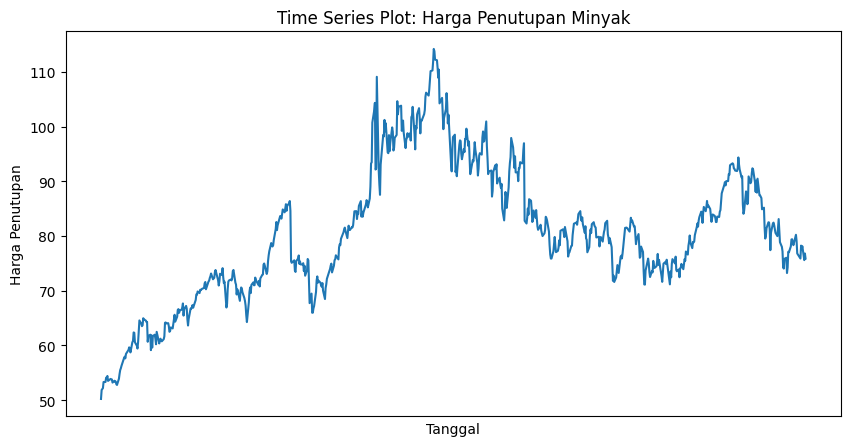

In [6]:
# Plot Time Series
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], y)
plt.title('Time Series Plot: Harga Penutupan Minyak')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.xticks([])

# Menampilkan plot
plt.show()

Berdasarkan plot diatas data memiliki trend dan teramsuk multiplikatif, pola musiman dalam data sulit diidentifikasi, sehingga analisa lanjutan yang tepat ialah menggunakan model **ARIMA**

# **Modeling**



Alasan memilih model ARIMA & LSTM

ARIMA umumnya bekerja dengan baik untuk data time series yang relatif stabil dan menunjukkan tren yang jelas. sedangkan model LSTM mampu menangkap pola yang rumit dan tidak terduga dalam data, yang mungkin terlewatkan oleh ARIMA.

## ARIMA

In [7]:
# Uji ADF
result_adf = adfuller(y)
print("\nHasil uji ADF:")
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')


Hasil uji ADF:
ADF Statistic: -2.496030617846645
p-value: 0.11644310796825835


Hasil uji ADF menunjukkan bahwa data **tidak stasioner**, karena p-value  lebih besar dari 0.05

In [8]:
# Differencing
data_diff = y.diff().dropna()
result_adf_diff = adfuller(data_diff)
print("\nHasil uji ADF setelah differencing:")
print(f'ADF Statistic: {result_adf_diff[0]}')
print(f'p-value: {result_adf_diff[1]}')


Hasil uji ADF setelah differencing:
ADF Statistic: -18.861425471491064
p-value: 0.0


Setelah differencing, data menjadi **stasioner**

In [9]:
model_arima1 = auto_arima(data["Close"], trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3207.420, Time=2.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3222.073, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3218.899, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3217.006, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3220.286, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3205.462, Time=0.91 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3205.436, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3205.365, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3207.188, Time=0.98 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3207.249, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3209.186, Time=2.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3203.788, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3203.808, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3205.601, Time=0.78 sec
 ARIMA(0,1,4)(0,0,0)[0]          

In [10]:
# ARIMA

model_arima = ARIMA(y, order=(0, 1, 3))
fit_arima = model_arima.fit()

forecast_arima = fit_arima.get_forecast(steps=30)   # Membuat prediksi dan mendapatkan interval kepercayaan
conf_int = forecast_arima.conf_int(alpha=0.05)

In [11]:
forecast_arima_values = forecast_arima.predicted_mean.values  # Assuming the values attribute contains the predicted values

# Evaluasi Model ARIMA
metrics_arima = calculate_metrics(y[-30:], forecast_arima_values)
print("\nMetrik Evaluasi Model ARIMA:")
print(metrics_arima)


Metrik Evaluasi Model ARIMA:
{'MAE': 2.0925334836329226, 'MSE': 7.037372519220275, 'RMSE': 2.652804651537741, 'R2': -0.41006498122322577}


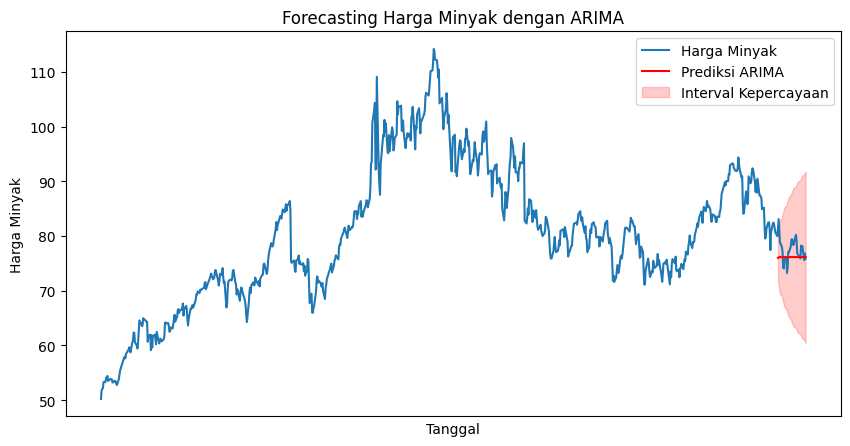

In [12]:
# Visualisasi Forecasting dengan ARIMA
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], y, label='Harga Minyak')
plt.plot(data['Date'][-30:], forecast_arima.predicted_mean, label='Prediksi ARIMA', linestyle='solid', color='red')

# Plot interval kepercayaan
plt.fill_between(data['Date'][-30:], conf_int['lower Close'], conf_int['upper Close'], color='red', alpha=0.2, label='Interval Kepercayaan')

plt.title('Forecasting Harga Minyak dengan ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Harga Minyak')
plt.xticks([])
plt.legend()
plt.show()

## LSTM

In [13]:
# Model LSTM
scaler = StandardScaler()
data_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [14]:
# Membagi data training dan testing
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

In [15]:
# Fungsi untuk membuat dataset dengan time steps
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [16]:
# Membuat dataset dengan time steps
time_steps = 1
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [17]:
# Reshape data untuk LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
# Membuat model LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, activation='relu', input_shape=(1, time_steps)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
# Melatih model LSTM
model_lstm.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
606/606 - 7s - loss: 0.3070 - 7s/epoch - 12ms/step
Epoch 2/100
606/606 - 3s - loss: 0.0323 - 3s/epoch - 4ms/step
Epoch 3/100
606/606 - 3s - loss: 0.0328 - 3s/epoch - 5ms/step
Epoch 4/100
606/606 - 4s - loss: 0.0319 - 4s/epoch - 6ms/step
Epoch 5/100
606/606 - 3s - loss: 0.0315 - 3s/epoch - 6ms/step
Epoch 6/100
606/606 - 3s - loss: 0.0308 - 3s/epoch - 5ms/step
Epoch 7/100
606/606 - 2s - loss: 0.0314 - 2s/epoch - 4ms/step
Epoch 8/100
606/606 - 3s - loss: 0.0313 - 3s/epoch - 4ms/step
Epoch 9/100
606/606 - 3s - loss: 0.0303 - 3s/epoch - 6ms/step
Epoch 10/100
606/606 - 3s - loss: 0.0308 - 3s/epoch - 5ms/step
Epoch 11/100
606/606 - 2s - loss: 0.0305 - 2s/epoch - 4ms/step
Epoch 12/100
606/606 - 2s - loss: 0.0310 - 2s/epoch - 4ms/step
Epoch 13/100
606/606 - 2s - loss: 0.0309 - 2s/epoch - 4ms/step
Epoch 14/100
606/606 - 4s - loss: 0.0310 - 4s/epoch - 6ms/step
Epoch 15/100
606/606 - 3s - loss: 0.0304 - 3s/epoch - 5ms/step
Epoch 16/100
606/606 - 2s - loss: 0.0313 - 2s/epoch - 4ms/step


In [20]:
# Prediksi menggunakan model LSTM
predicted_values_lstm = model_lstm.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

5/5 [==============================] - 0s 3ms/step


In [21]:
# Evaluate Model LSTM
actual_values_lstm = y[-len(predicted_values_lstm):].values  # Convert to NumPy array

# Ensure both actual and predicted values have the same length
if len(actual_values_lstm) != len(predicted_values_lstm):
    print("Length mismatch between actual and predicted values.")
else:
    # Calculate metrics
    metrics_lstm = calculate_metrics(actual_values_lstm, predicted_values_lstm)
    print("\nMetrics Evaluation for LSTM Model:")
    print(metrics_lstm)


Metrics Evaluation for LSTM Model:
{'MAE': 1.2570060881557847, 'MSE': 2.611268115062457, 'RMSE': 1.615941866238528, 'R2': 0.9273315827026671}


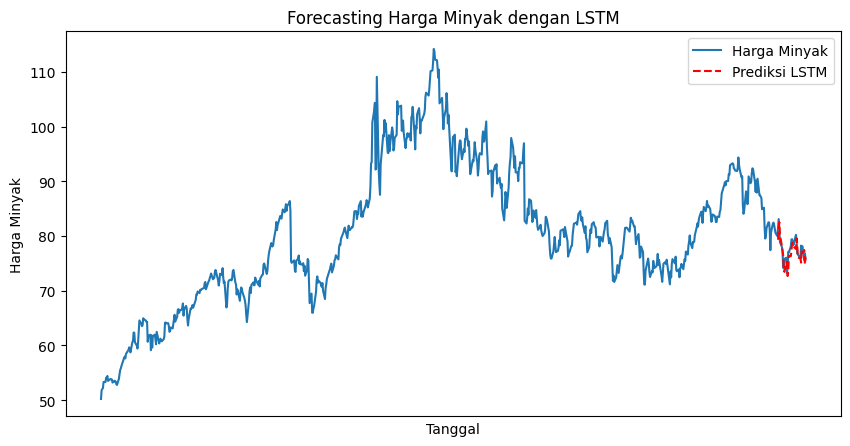

In [22]:
# Visualisasi Forecasting dengan LSTM
plt.figure(figsize=(10, 5))
last_30_days = data['Date'].tail(30)  # Adjust to get the last 30 days
plt.plot(data['Date'], y, label='Harga Minyak')
plt.plot(last_30_days, predicted_values_lstm.flatten()[-30:], label='Prediksi LSTM', linestyle='dashed', color='red')
plt.title('Forecasting Harga Minyak dengan LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Harga Minyak')
plt.xticks([])
plt.legend()
plt.show()

**💡Insight**

Model LSTM menunjukkan kinerja yang lebih baik berdasarkan nilai metrik evaluasi. Dengan MAE dan RMSE yang lebih rendah,  model LSTM mampu menangkap pola dan hubungan yang lebih kompleks dalam data harga minyak, sehingga menghasilkan prediksi yang lebih akurat secara keseluruhan. Model ARIMA, meskipun masih memberikan performa dasar, tampaknya kurang efektif dalam menangani non-linearitas dan dinamika rumit pergerakan harga minyak.

# Forecasting

In [23]:
# Prediksi untuk beberapa hari ke depan dengan LSTM
days_to_predict = 15
last_data = np.array([test_data[-1]])
predicted_values_future = []

for i in range(days_to_predict):
    prediction = model_lstm.predict(np.reshape(last_data, (1, 1, 1)))
    last_data = np.array([prediction])
    prediction_inverse = scaler.inverse_transform(prediction)
    predicted_values_future.append(prediction_inverse[0, 0])

1/1 [==============================] - 0s 27ms/step


In [24]:
# Ubah tipe data jadi datetime
data['Date'] = pd.to_datetime(data['Date'])

# Membuat dataframe hasil prediksi
date_future = pd.date_range(start=data['Date'].max() + pd.to_timedelta(1, unit='D'), periods=days_to_predict)
future_df = pd.DataFrame({'Date': date_future, 'Predicted_Price': predicted_values_future})

# Menampilkan dataframe hasil prediksi
print("\nHasil Prediksi Harga Minyak untuk 30 Hari ke Depan:")
print(future_df)


Hasil Prediksi Harga Minyak untuk 30 Hari ke Depan:
         Date  Predicted_Price
0  2024-01-11        75.149086
1  2024-01-12        74.448479
2  2024-01-13        73.815437
3  2024-01-14        73.242332
4  2024-01-15        72.696289
5  2024-01-16        72.131630
6  2024-01-17        71.547478
7  2024-01-18        70.966087
8  2024-01-19        70.384125
9  2024-01-20        69.797241
10 2024-01-21        69.200996
11 2024-01-22        68.590691
12 2024-01-23        67.961243
13 2024-01-24        67.307007
14 2024-01-25        66.621597


In [25]:
# Visualisasi Forecasting
import plotly.express as px

# Membuat dataframe untuk plot
future_plot = pd.DataFrame({
    'Date': pd.date_range(start=data['Date'].min(), periods=len(data['Date']) + days_to_predict, freq='D'),
    'Price': np.concatenate([y.values, np.full(days_to_predict, np.nan)]),
    'Predicted_Price': np.concatenate([np.full(len(data['Date']), np.nan), predicted_values_future])
})

# Membuat plot interaktif menggunakan Plotly Express
fig = px.line(future_plot, x='Date', y=['Price', 'Predicted_Price'], labels={'value': 'Harga Minyak'})

# Menambahkan informasi tambahan ke dalam tooltip
fig.update_traces(
    hovertemplate='<b>%{y:,.2f}</b><br>%{x|%A, %d %B %Y}',
    hoverinfo='y+name+x'
)

# Menyesuaikan layout plot
fig.update_layout(title='Prediksi Harga Minyak Beberapa Hari ke Depan', xaxis_title='Tanggal', yaxis_title='Harga Minyak')

# Menampilkan plot
fig.show()

# Evaluasi

Metrik evaluasi untuk model time series seperti ARIMA dan LSTM memberikan wawasan tentang keakuratan prediksi model. Mean Absolute Error (MAE) mengukur rata-rata perbedaan absolut antara nilai aktual dan prediksi, menunjukkan rata-rata kesalahan prediksi. Mean Squared Error (MSE) mengukur rata-rata kuadrat perbedaan, memberikan bobot lebih besar pada kesalahan besar. Root Mean Squared Error (RMSE) adalah akar kuadrat MSE, memberikan skala kesalahan dalam unit data asli. R-squared (R²) menunjukkan seberapa baik model menjelaskan varians data, dengan nilai mendekati 1 menunjukkan penjelasan yang baik.


Metrik evaluasi untuk model time series seperti ARIMA dan LSTM memberikan wawasan tentang keakuratan prediksi model. Mean Absolute Error (MAE) mengukur rata-rata perbedaan absolut antara nilai aktual dan prediksi, menunjukkan rata-rata kesalahan prediksi. Mean Squared Error (MSE) mengukur rata-rata kuadrat perbedaan, memberikan bobot lebih besar pada kesalahan besar. Root Mean Squared Error (RMSE) adalah akar kuadrat MSE, memberikan skala kesalahan dalam unit data asli. R-squared (R²) menunjukkan seberapa baik model menjelaskan varians data, dengan nilai mendekati 1 menunjukkan penjelasan yang baik.


**Kesimpulan**:

Model LSTM direkomendasikan untuk memprediksi harga minyak dunia karena akurasinya yang lebih tinggi dan kemampuannya untuk menjelaskan varians data dengan lebih baik. Namun, penting untuk dicatat bahwa performa model dapat bervariasi tergantung pada karakteristik data dan pilihan hyperparamete

# **EXPLORE !!**

In [26]:
# Ubah kolom 'Date' ke format datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Day_of_Week'] = data['Date'].dt.day_name()

# Hitung total closing per hari
daily_closing_total = data.groupby('Day_of_Week')['Close'].sum().sort_values(ascending=False).reset_index()

# Plot Horizontal Bar Chart dengan Plotly Express
fig = px.bar(daily_closing_total, x='Close', y='Day_of_Week', orientation='h', color='Day_of_Week',
             labels={'Close': 'Total Closing', 'Day_of_Week': 'Hari'})

# Menyesuaikan layout plot
fig.update_layout(title='Total Closing per Hari dalam Seminggu', xaxis_title='Total Closing', yaxis_title='Hari')

# Menampilkan plot
fig.show()

Dari analisis data harga penutupan minyak selama hari kerja, terlihat bahwa pada hari Senin, harga penutupan cenderung lebih rendah dibandingkan dengan hari-hari kerja lainnya. Hal ini bisa menjadi indikasi bahwa pada awal minggu, terdapat tren penurunan harga minyak yang kemungkinan terkait dengan faktor-faktor ekonomi atau kebijakan pasar pada awal pekan.

In [27]:
# PERBANDINGAN HARGA TERTINGGI & TERENDAH
import plotly.express as px

# Assuming data is your DataFrame
fig = px.scatter(data, x='Low', y='High', trendline="ols", color='Close', size='Close', height=600,
                 labels={'Low': 'Harga Terendah', 'High': 'Harga Tertinggi'})

# Menambahkan informasi tambahan ke dalam tooltip
fig.update_traces(
    hovertemplate='<b>%{marker.size:,}</b><br>Harga Terendah: %{x:.2f}<br>Harga Tertinggi: %{y:.2f}<br>Tanggal: %{text}',
    hoverinfo='text+x+y',
    text=data['Date'].dt.date  # Menggunakan dt.date untuk hanya menampilkan tanggal
)

# Menyesuaikan layout plot dan menghapus legend
fig.update_layout(title='Scatter Plot dengan Regresi Interaktif', xaxis_title='Harga Terendah',
                  yaxis_title='Harga Tertinggi', coloraxis_colorbar=dict(title='Harga Penutupan'))

# Menampilkan plot
fig.show()